# Import modules

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from discretize import TensorMesh
from discretize.utils import mkvc
from dwave.system import EmbeddingComposite, DWaveSampler
from neal import SimulatedAnnealingSampler
from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
)
from SimPEG.utils import surface2ind_topo
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import dwaveutils.inverse as dwinv
from dwaveutils.utils import Binary2Float

# suppress all warnings
warnings.filterwarnings('ignore')
# create random generator
rng = np.random.default_rng(1234)

# Set up forward modeling

## Defining topography

In [2]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-5, 5, 11), np.linspace(-5, 5, 11)
)
z_topo = np.zeros_like(x_topo)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]
topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

## Create dipole-dipole survey

In [3]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-5, 5]
station_separation = 1
num_rx_per_src = 10

# Generate source list for DC survey line
source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
survey = dc.survey.Survey(source_list, survey_type=survey_type)

print("Survey locations header:")
print("Ax, Az, Bx, Bz, Mx, Mz, Nx, Nz")
print("Survey locations:")
print(np.c_[survey.locations_a, survey.locations_b, survey.locations_m, survey.locations_n])

Survey locations header:
Ax, Az, Bx, Bz, Mx, Mz, Nx, Nz
Survey locations:
[[-5.  0. -4.  0. -3.  0. -2.  0.]
 [-5.  0. -4.  0. -2.  0. -1.  0.]
 [-5.  0. -4.  0. -1.  0.  0.  0.]
 [-5.  0. -4.  0.  0.  0.  1.  0.]
 [-5.  0. -4.  0.  1.  0.  2.  0.]
 [-5.  0. -4.  0.  2.  0.  3.  0.]
 [-5.  0. -4.  0.  3.  0.  4.  0.]
 [-5.  0. -4.  0.  4.  0.  5.  0.]
 [-4.  0. -3.  0. -2.  0. -1.  0.]
 [-4.  0. -3.  0. -1.  0.  0.  0.]
 [-4.  0. -3.  0.  0.  0.  1.  0.]
 [-4.  0. -3.  0.  1.  0.  2.  0.]
 [-4.  0. -3.  0.  2.  0.  3.  0.]
 [-4.  0. -3.  0.  3.  0.  4.  0.]
 [-4.  0. -3.  0.  4.  0.  5.  0.]
 [-3.  0. -2.  0. -1.  0.  0.  0.]
 [-3.  0. -2.  0.  0.  0.  1.  0.]
 [-3.  0. -2.  0.  1.  0.  2.  0.]
 [-3.  0. -2.  0.  2.  0.  3.  0.]
 [-3.  0. -2.  0.  3.  0.  4.  0.]
 [-3.  0. -2.  0.  4.  0.  5.  0.]
 [-2.  0. -1.  0.  0.  0.  1.  0.]
 [-2.  0. -1.  0.  1.  0.  2.  0.]
 [-2.  0. -1.  0.  2.  0.  3.  0.]
 [-2.  0. -1.  0.  3.  0.  4.  0.]
 [-2.  0. -1.  0.  4.  0.  5.  0.]
 [-1.  0.  0.  0

## Create mesh

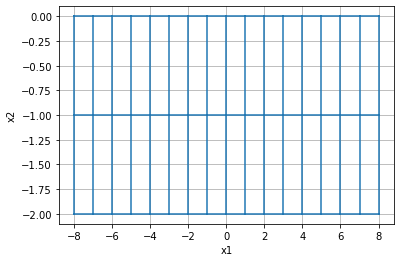

In [4]:
dh = 1  # base cell width
nbcx = 16  # num. base cells x
nbcz = 2  # num. base cells z

hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
origin = [0, 0]
mesh = TensorMesh([hx, hz], origin="CN")
mesh.plot_grid()
plt.show()

## Create resistivity model and mapping for mesh

In [5]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
# air_conductivity = 1e-8
air_resistivity = 1e8

# Find active cells in forward modeling (cell below surface)
ind_active = surface2ind_topo(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
# conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)
resistivity_map = maps.InjectActiveCells(mesh, ind_active, air_resistivity)

simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=resistivity_map, Solver=Solver
)

## Create `fwd_model` function

In [6]:
num_params = mesh.n_cells  # number of model parameters
def fwd_model(model_params):
    return simulation.make_synthetic_data(model_params, add_noise=False).dclean

# Set up inverse problem

## Create synthetic observed response

In [7]:
diff_params = 2990  # difference between low_param and high_param
low_param_value = 10.0
high_param_value = low_param_value + diff_params

num_obs = simulation.survey.nD  # number of observations
bin_model_params = rng.integers(0, 2, size=num_params)
model_params = Binary2Float.to_two_value(bin_model_params, low_param_value, high_param_value)

obs_resp = dwinv.utils.fwd_modeling(fwd_model, model_params)

# Solve inverse problem with sampling

In [8]:
initial_bin_model_params = rng.integers(0, 2, size=num_params)  # initial guess
problem_params = {
    "fwd_model_func": fwd_model,
    "obs_resp": obs_resp,
    "low_high": (low_param_value, high_param_value),
}
problem = dwinv.problem.BinaryInverseProblem(problem_params)

sampler = SimulatedAnnealingSampler()
# sampler = EmbeddingComposite(
#     DWaveSampler(solver={'qpu': True}, postprocess="sampling")
# )  # use postprocess
sampling_params = {"num_reads": 100}
iter_params = {"num_iter": 50, "verbose": True}
solver = dwinv.solver.BinaryInverseIterativeSolver(problem, sampler, sampling_params, iter_params)

result = solver.solve(initial_bin_model_params, iter_params=iter_params)

Iteration: 0
  - bin_model_params = [0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0]
  - qubo_obj = -1.27018057e+01
  - obj = 8.54241948e+04
Iteration: 1
  - bin_model_params = [0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0]
  - qubo_obj = -1.44178718e+04
  - obj = 8.49736853e+04
Iteration: 2
  - bin_model_params = [1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
  - qubo_obj = -7.65174086e+03
  - obj = 8.61691259e+04
Iteration: 3
  - bin_model_params = [1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0]
  - qubo_obj = -2.78753599e+03
  - obj = 7.24567349e+04
Iteration: 4
  - bin_model_params = [1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0]
  - qubo_obj = -7.15729074e+03
  - obj = 7.65179387e+04
Iteration: 5
  - bin_model_params = [1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0]
  - qubo_obj = -2.05883230e+04
  - obj = 8.60172760e+04
Iteration: 6
  - bin_model_params = [0 0 1 0 1 0 0 1

# Show result

## Compare predicted and synthetic model parameters

In [9]:
print(f"Predicted bin_model_params = {result['bin_model_params']}")
print(f"Synthetic bin_model_params = {bin_model_params}")

num_wrong = sum(abs(bin_model_params - result["bin_model_params"]))
percentc = (100 * (num_params - num_wrong) / num_params)
print(f"  - # wrong = {num_wrong}")
print(f"  - % correct = {percentc:.1f} %")

Predicted bin_model_params = [1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0]
Synthetic bin_model_params = [1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1]
  - # wrong = 14
  - % correct = 56.2 %


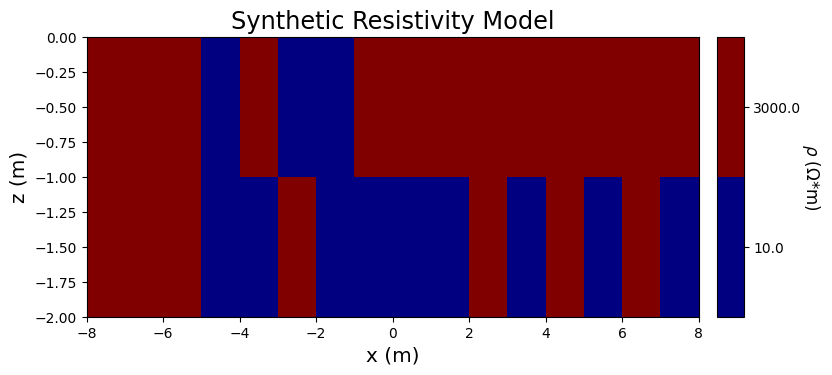

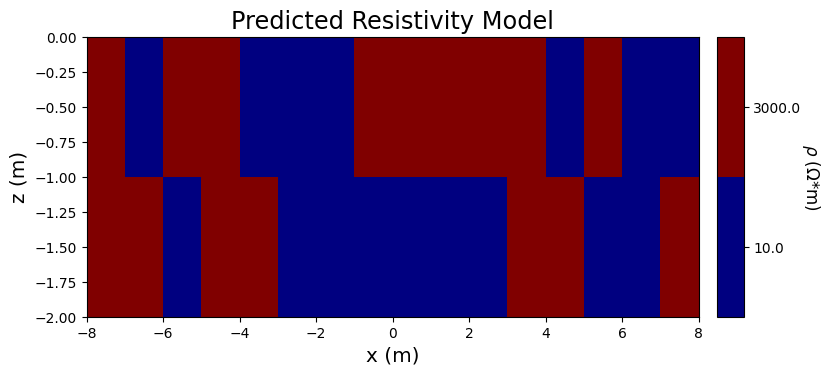

In [10]:
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

plot_params = {
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'font.size': 12,
    'figure.figsize': [8, 6],
    'figure.titlesize': 'x-large',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'legend.fontsize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
}
mpl.rcdefaults()  # add this line for the update to take effect
mpl.rcParams.update(plot_params)

# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
num_discrete_value = 2
cmap = discrete_cmap(num_discrete_value, "jet")
norm_bins = np.arange(num_discrete_value) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
cbar_ticklabels = np.array([low_param_value, high_param_value])
norm = mpl.colors.BoundaryNorm(norm_bins, num_discrete_value, clip=True)
formatter = mpl.ticker.FuncFormatter(lambda x, pos: cbar_ticklabels[norm(x)])
cbar_ticks = norm_bins[:-1] + (norm_bins[1:] - norm_bins[:-1]) / 2

models = [bin_model_params, result["bin_model_params"]]
titles = ["Synthetic Resistivity Model", "Predicted Resistivity Model"]
for i in range(2):
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
    im = mesh.plot_image(
        models[i], ax=ax1, grid=False, pcolor_opts={"norm": norm, "cmap": cmap}
    )
    ax1.set_title(titles[i])
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("z (m)")
    ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
    cbar = fig.colorbar(im[0], cax=ax2, format=formatter, ticks=cbar_ticks)
    cbar.set_label(r"$\rho$ ($\Omega$*m)", rotation=270, labelpad=15, size=12)
plt.show()
mpl.rcdefaults()

## Compare predicted and observed responses

In [11]:
pred_resp = dwinv.utils.fwd_modeling(fwd_model, result["bin_model_params"], (low_param_value, high_param_value))

with np.printoptions(precision=8, suppress=True):
    print(f"Predicted response =\n{pred_resp}\n")
    print(f"Observed response  =\n{obs_resp}\n")
    print(f"Residual sum of squares = {result['obj']:.8e}")

Predicted response =
[  -1.49876397   -0.40344131   -0.58136819   -0.26042559   -0.12492322
   -0.08983942   -0.19252501   -0.00079099   -0.28531073   -0.15508295
   -0.04170224   -0.01288801   -0.00505205   -0.00606188   -0.00002133
   -0.95523233   -0.20997719   -0.056501     -0.01944066   -0.02004756
   -0.00006859   -0.96291316   -0.20215545   -0.05468095   -0.03821111
   -0.00011683 -163.40868433  -32.22866128   -8.85692269   -0.01253149
 -140.01031777  -32.48020657   -0.04152864 -163.66390796   -0.180984
   -0.92218484]

Observed response  =
[  -0.02894189   -0.00971457   -0.01276861   -0.0051316    -0.0023205
   -0.00281353   -0.0007625    -0.00028697   -1.03382392   -0.75636596
   -0.24340072   -0.09428874   -0.09858881   -0.02658209   -0.0099176
   -0.84308812   -0.1947727    -0.05921624   -0.04641318   -0.01222362
   -0.00433602   -0.9487633    -0.1990954    -0.07606284   -0.01881891
   -0.00579168 -163.27842383  -32.02619344   -7.06382471   -1.71368259
 -138.86252035  -26.53

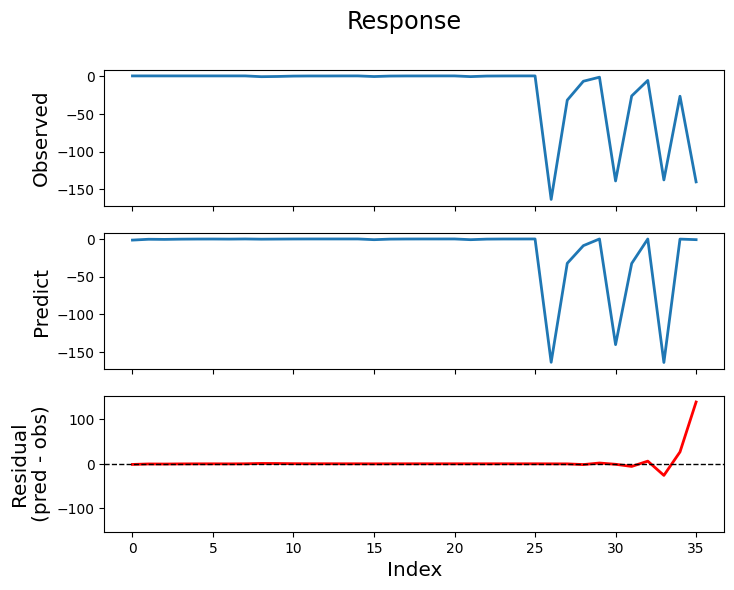

In [12]:
mpl.rcParams.update(plot_params)

fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(obs_resp)
ax[0].set_ylabel("Observed")

ax[1].plot(pred_resp)
ax[1].set_ylabel("Predict")

ax[2].plot(pred_resp - obs_resp, color="red")
ax[2].set_ylim(-1.1 * max(abs(pred_resp - obs_resp)), 1.1 * max(abs(pred_resp - obs_resp)))
ax[2].axhline(color="black", linestyle="--", linewidth=1)
ax[2].set_xlabel("Index")
ax[2].set_ylabel("Residual\n(pred - obs)")

plt.suptitle("Response")

plt.show()
mpl.rcdefaults()

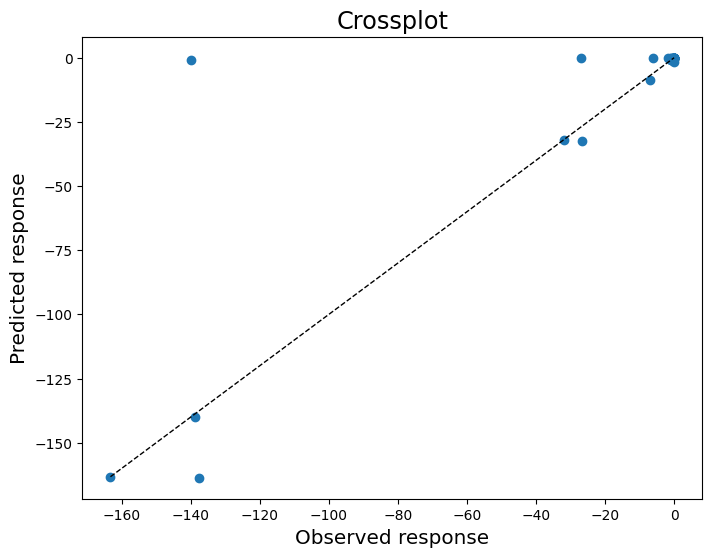

In [13]:
mpl.rcParams.update(plot_params)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
ax.scatter(obs_resp, pred_resp)
ax.plot([np.min(obs_resp), np.max(obs_resp)], [np.min(obs_resp), np.max(obs_resp)], color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Observed response")
ax.set_ylabel("Predicted response")
ax.set_title("Crossplot")
plt.show()

mpl.rcdefaults()